# 0.a. Import and settings

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext rpy2.ipython

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import scanpy as sc
from scanpy.plotting._tools.scatterplots import plot_scatter
import scanpy_scripts as ss
import bbknn

expr_cmap = ss.lib.expression_colormap(background_level=0.01)
np.set_printoptions(linewidth=180)
sc.settings.verbosity = 1
sc.settings.figdir = 'png'

# 0.b. Define functions

In [3]:
import warnings
warnings.filterwarnings(action='ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
def diffexp(
    adata, basis='umap', key=None, res=None, method='logreg',
    filter_params={'min_in_group_fraction': 0.4, 'max_out_group_fraction': 0.2, 'min_fold_change': 2},
    extra_genes=None, **kwargs
):
    if key:
        grp_key = f'{key}_r{str(res).replace(".", "_")}'
        basis=f'{basis}_{key}'
    else:
        grp_key = f'r{str(res).replace(".", "_")}'
    de_tbl = ss.lib.diffexp(
        adata, key_added=grp_key, groupby=f'leiden_{grp_key}', method=method,
        filter_params=filter_params, **kwargs,
    )
    de_genes = list(de_tbl.groupby('cluster').head(4)['genes'].values)
    if extra_genes:
        de_genes.extend(extra_genes)
    rcParams.update({'figure.figsize': (4,4)})
    sc.pl.rank_genes_groups(adata, key=f'rank_genes_groups_{grp_key}', show=False)

    sc.pl.dotplot(
        adata,
        var_names=de_genes,
        groupby=f'leiden_{grp_key}',
        #standard_scale='var',
        show=False
    )

    rcParams.update({'figure.figsize':(2.5,2.5)})
    plot_scatter(
        adata, basis=basis, color_map=expr_cmap, use_raw=True, ncols=8, size=10, color=de_genes, show=False)
    rcParams.update({'figure.figsize':(3,3)})
    ss.lib.plot_embedding(adata, basis=basis, groupby=f'leiden_{grp_key}', size=20, show=False)
    return de_tbl

# 1. Load data

In [60]:
CATEGORY_NAME = 'endothelium'
CATEGORY_CLUSTER_ID = 4
MIN_BATCH_SIZE = 10
DE_METHOD = 't-test_overestim_var'
DE_FILTERS = {'min_in_group_fraction': 0.4, 'max_out_group_fraction': 0.2, 'min_fold_change': 1.5}
KNOWN_MARKERS = ['CCL21', 'PECAM1']

In [7]:
# 1. Load data
fetal_ad = sc.read('data/h5ad/fetal_skin_raw.20190926.h5ad', mode='r')

# Restrict to category of interest
ad = fetal_ad[(fetal_ad.obs['hierarchy1'] == CATEGORY_CLUSTER_ID), :]

# Remove samples with too few cells
sample_sizes = ad.obs['sample'].value_counts()
valid_batches = sample_sizes[sample_sizes >= MIN_BATCH_SIZE].index.to_list()
ad = ad[ad.obs['sample'].isin(valid_batches), :]

ad.write(f'data/h5ad/fetal_skin_hierarch1_{CATEGORY_NAME}.h5ad', compression='gzip')

In [13]:
ad

AnnData object with n_obs × n_vars = 3636 × 33694 
    obs: 'bh_doublet_pval', 'cell_caller', 'cluster_scrublet_score', 'doublet_pval', 'mt_prop', 'n_counts', 'n_genes', 'sanger_id', 'scrublet_score', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'annot', 'hierarchy1', 'percent_mito', 'percent_ribo', 'percent_hb'
    var: 'gene_ids', 'cc', 'mito', 'ribo', 'hb', 'n_cells'
    uns: 'chemistry_sorting_colors'

# 2. QC

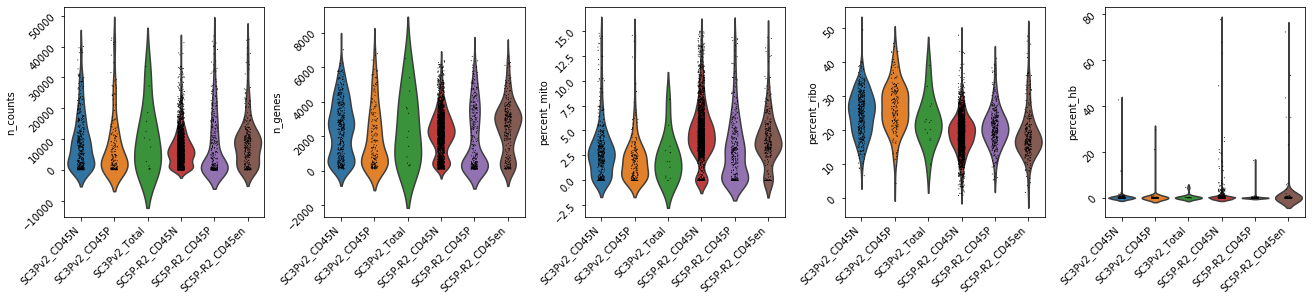

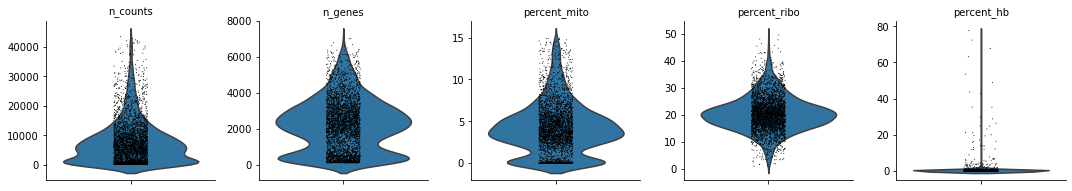

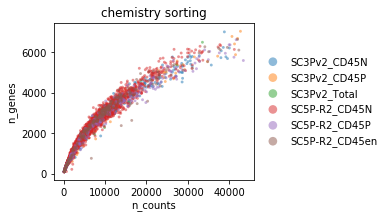

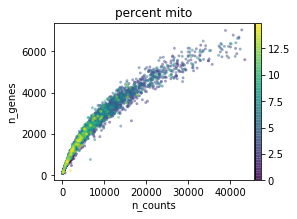

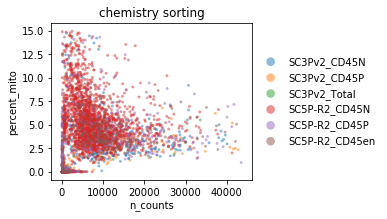

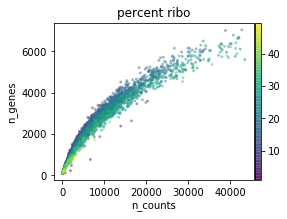

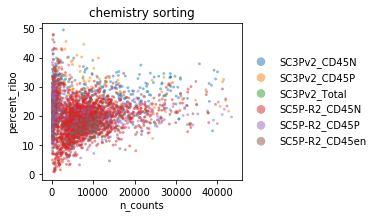

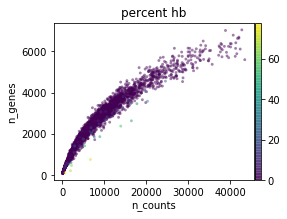

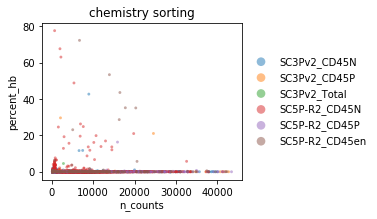

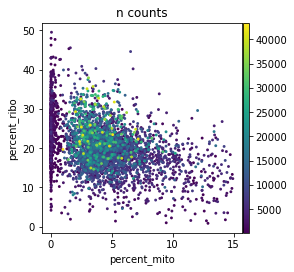

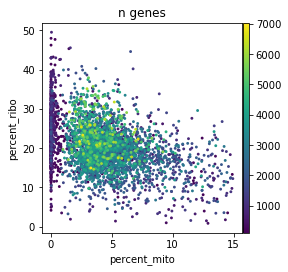

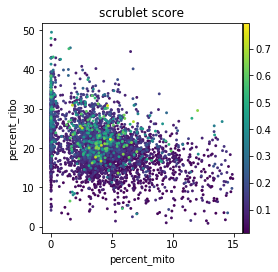

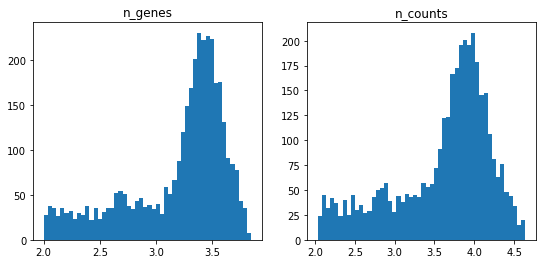

In [19]:
ss.lib.set_figsize((4,4))
ss.lib.simple_default_pipeline(ad, qc_only=True, batch='chemistry_sorting')
sc.pl.scatter(ad, x='percent_mito', y='percent_ribo', color='n_counts')
sc.pl.scatter(ad, x='percent_mito', y='percent_ribo', color='n_genes')
sc.pl.scatter(ad, x='percent_mito', y='percent_ribo', color='scrublet_score')

ss.lib.set_figsize((9,4))
fig, ax = plt.subplots(ncols=2)
_ = ax[0].hist(np.log10(ad.obs.loc[(ad.obs['percent_mito']>1) & (ad.obs['percent_mito']<11), 'n_genes']), bins=50)
ax[0].set_title('n_genes')
_ = ax[1].hist(np.log10(ad.obs.loc[(ad.obs['percent_mito']>1) & (ad.obs['percent_mito']<11), 'n_counts']), bins=50)
ax[1].set_title('n_counts')
ss.lib.set_figsize((4,4))

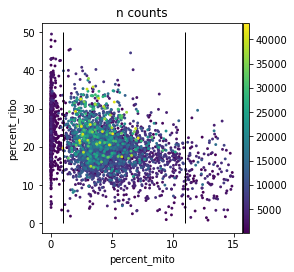

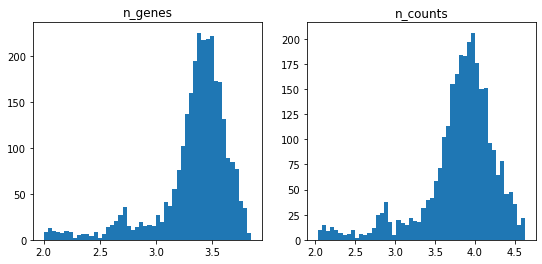

In [22]:
ss.lib.set_figsize((4,4))
ax = sc.pl.scatter(ad, x='percent_mito', y='percent_ribo', color='n_counts', show=False)
ax.vlines(x=[1, 11], ymin=0, ymax=50, linewidth=1)
ss.lib.set_figsize((9,4))
fig, ax = plt.subplots(ncols=2)
_ = ax[0].hist(np.log10(ad.obs.loc[(ad.obs['percent_mito']>1) & (ad.obs['percent_mito']<11), 'n_genes']), bins=50)
ax[0].set_title('n_genes')
_ = ax[1].hist(np.log10(ad.obs.loc[(ad.obs['percent_mito']>1) & (ad.obs['percent_mito']<11), 'n_counts']), bins=50)
ax[1].set_title('n_counts')
ss.lib.set_figsize((4,4))

# 3. Default preprocessing

In [23]:
MIN_PCT_MITO = 1
MAX_PCT_MITO = 11
MIN_N_GENE = 300
MIN_N_UMI = 300
MAX_PCT_HB = 2.5
MIN_N_CELL = 3
CLUSTER_RESOLUTIONS = [0.1, 0.2, 0.3, 0.4, 0.5]

In [24]:
ad = ad[
    (ad.obs.percent_mito >= MIN_PCT_MITO) &
    (ad.obs.percent_mito < MAX_PCT_MITO) &
    (ad.obs.n_genes >= MIN_N_GENE) &
    (ad.obs.n_counts >= MIN_N_UMI) &
    (ad.obs.percent_hb < MAX_PCT_HB), :]
ad = ad[:, (ad.var.n_cells >= MIN_N_CELL)]

In [25]:
ad1 = ad.copy()[:, ~(ad.var.mito | ad.var.hb | ad.var.ribo)]

ss.lib.simple_default_pipeline(
    ad1,
    filter_params=None,
    hvg_params={'flavor': 'seurat', 'by_batch': ['chemistry', 2]},
    scale_params={'max_value': 10},
    pca_params={'n_comps': 50, 'svd_solver': 'arpack', 'use_highly_variable': True},
    harmony_params=None,
    nb_params={'use_rep': 'X_pca', 'key_added': 'orig'},
    umap_params={'use_graph': 'neighbors_orig', 'key_added': 'orig'},
    leiden_params={'resolution': CLUSTER_RESOLUTIONS, 'use_graph': 'neighbors_orig', 'key_added': 'orig'},
    tsne_params=None, diffmap_params=None, fdg_params=None,
)

k_annot = (ad1.obs['annot'] != 'nan').values
ad1.obs['lr_annot'] = ss.lib.LR_annotate(
    ad1, train_label=ad1.obs['annot'].values, train_x=ad1.obsm['X_pca'], subset=k_annot, use_rep='X_pca', return_label=True)
ad1.obs['lr_annot'] = ad1.obs['lr_annot'].astype('category')

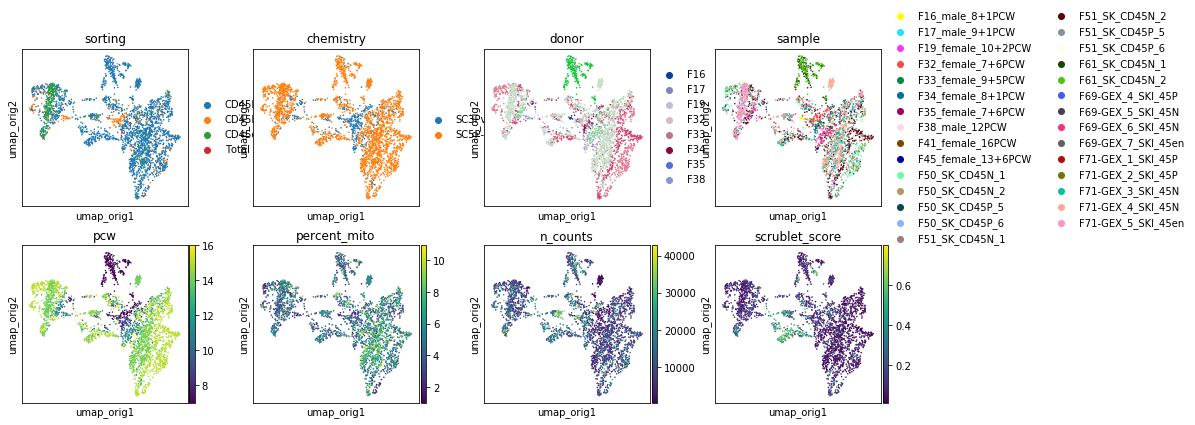

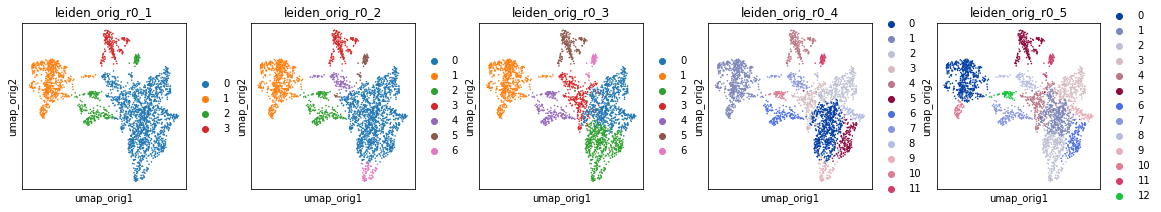

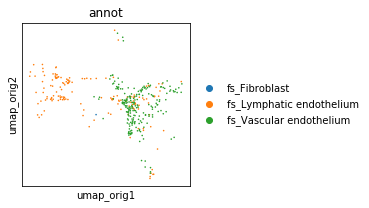

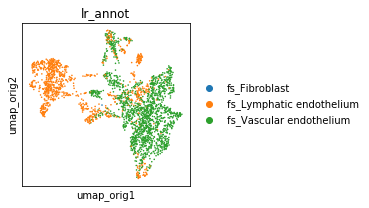

                      freq         p
leiden_orig_r0_1                    
0                 0.014778  0.831227
1                 0.027687  0.753160
2                 0.116732  0.000007
3                 0.000000  0.849550
                     score             p
leiden_orig_r0_1                        
0                 0.081478  8.662114e-01
1                 0.108112  7.932798e-01
2                 0.331462  3.806289e-12
3                 0.122855  7.932798e-01


In [32]:
ad1.obs['doublet'] = ad1.obs['bh_doublet_pval'] < 0.05
ad1.obs['doublet'] = ad1.obs['doublet'].astype('category')
ss.lib.set_figsize((3,3))
plot_scatter(
    ad1, basis='umap_orig', size=10,
    color=['sorting', 'chemistry', 'donor', 'sample', 'pcw', 'percent_mito', 'n_counts', 'scrublet_score'])
plot_scatter(
    ad1, basis='umap_orig', size=10, ncols=len(CLUSTER_RESOLUTIONS),
    color=[f'leiden_orig_r{str(res).replace(".", "_")}' for res in CLUSTER_RESOLUTIONS])
plot_scatter(
    ad1[k_annot, :], basis='umap_orig', size=10,
    color='annot')
plot_scatter(
    ad1, basis='umap_orig', size=10,
    color='lr_annot')

doublet_freq = ad1.obs.groupby('leiden_orig_r0_1')['doublet'].agg(lambda x: sum(x)/len(x))
_, p = ss.lib.test_outlier(doublet_freq, upper_mad_only=False)
print(pd.DataFrame({'freq': doublet_freq, 'p': p}))

doublet_freq = ad1.obs.groupby('leiden_orig_r0_1')['scrublet_score'].agg(lambda x: sum(x)/len(x))
_, p = ss.lib.test_outlier(doublet_freq, upper_mad_only=False)
print(pd.DataFrame({'score': doublet_freq, 'p': p}))

In [33]:
ad2 = ad.copy()[:,~(ad.var.mito | ad.var.hb | ad.var.ribo | ad.var.cc)]

ss.lib.simple_default_pipeline(
    ad2,
    filter_params=None,
    hvg_params={'flavor': 'seurat', 'by_batch': ['chemistry', 2]},
    scale_params={'max_value': 10},
    pca_params={'n_comps': 50, 'svd_solver': 'arpack', 'use_highly_variable': True},
    harmony_params=None,
    nb_params={'use_rep': 'X_pca', 'key_added': 'orig'},
    umap_params={'use_graph': 'neighbors_orig', 'key_added': 'orig'},
    leiden_params={'resolution': CLUSTER_RESOLUTIONS, 'use_graph': 'neighbors_orig', 'key_added': 'orig'},
    tsne_params=None, diffmap_params=None, fdg_params=None,
)

k_annot = (ad2.obs['annot'] != 'nan').values
ad2.obs['lr_annot'] = ss.lib.LR_annotate(
    ad2, train_label=ad2.obs['annot'].values, train_x=ad2.obsm['X_pca'], subset=k_annot, use_rep='X_pca', return_label=True)
ad2.obs['lr_annot'] = ad2.obs['lr_annot'].astype('category')

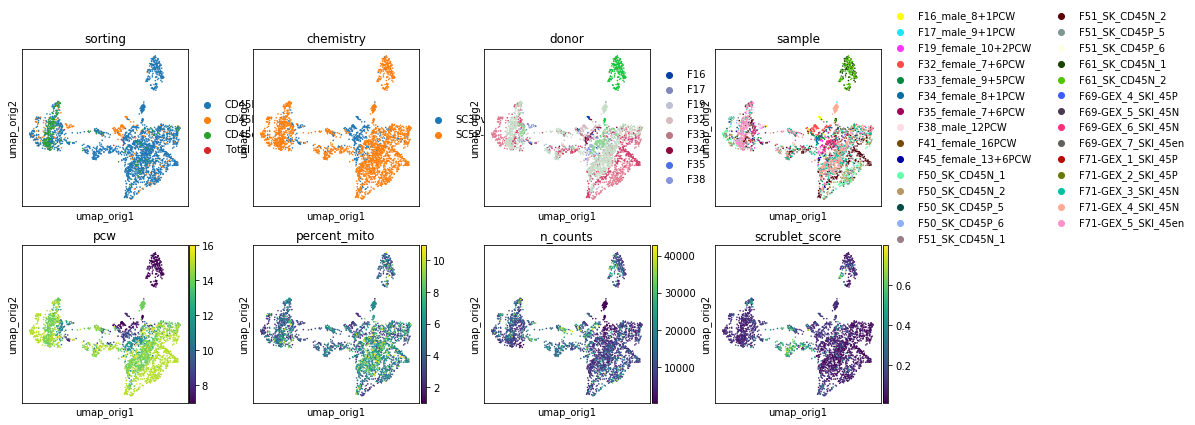

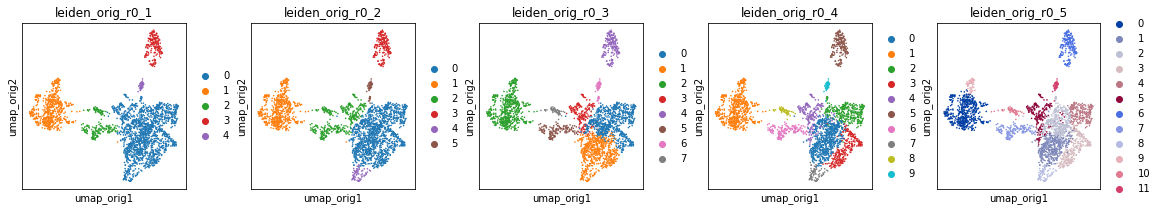

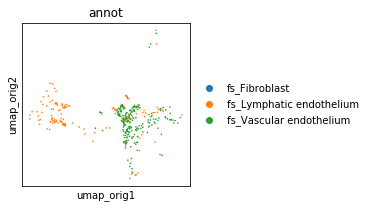

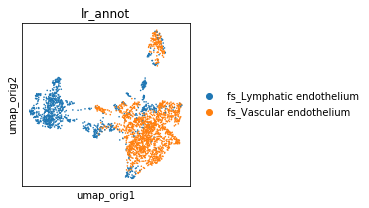

                      freq             p
leiden_orig_r0_1                        
0                 0.013597  7.500003e-01
1                 0.027419  6.161544e-01
2                 0.156098  3.905765e-12
3                 0.000000  7.500003e-01
4                 0.000000  7.500003e-01
                     score             p
leiden_orig_r0_1                        
0                 0.080596  7.524610e-01
1                 0.110816  7.524610e-01
2                 0.391181  6.143935e-10
3                 0.124322  7.524610e-01
4                 0.080940  7.524610e-01


In [35]:
ad2.obs['doublet'] = ad2.obs['bh_doublet_pval'] < 0.05
ad2.obs['doublet'] = ad2.obs['doublet'].astype('category')

ss.lib.set_figsize((3,3))
plot_scatter(
    ad2, basis='umap_orig', size=10,
    color=['sorting', 'chemistry', 'donor', 'sample', 'pcw', 'percent_mito', 'n_counts', 'scrublet_score'])
plot_scatter(
    ad2, basis='umap_orig', size=10, ncols=len(CLUSTER_RESOLUTIONS),
    color=[f'leiden_orig_r{str(res).replace(".", "_")}' for res in CLUSTER_RESOLUTIONS])
plot_scatter(ad2[k_annot, :], basis='umap_orig', size=10, color='annot')
plot_scatter(ad2, basis='umap_orig', size=10, color='lr_annot')


doublet_freq = ad2.obs.groupby('leiden_orig_r0_1')['doublet'].agg(lambda x: sum(x)/len(x))
_, p = ss.lib.test_outlier(doublet_freq, upper_mad_only=False)
print(pd.DataFrame({'freq': doublet_freq, 'p': p}))

doublet_freq = ad2.obs.groupby('leiden_orig_r0_1')['scrublet_score'].agg(lambda x: sum(x)/len(x))
_, p = ss.lib.test_outlier(doublet_freq, upper_mad_only=False)
print(pd.DataFrame({'score': doublet_freq, 'p': p}))

# 4.1 Harmony

In [57]:
ss.lib.simple_default_pipeline(
    ad1,
    filter_params=None, norm_params=None, hvg_params=None, scale_params=None, pca_params=None,
    harmony_params={'batch': 'sample', 'key_added': 'hm'},
    nb_params={'use_rep': 'X_pca_hm', 'key_added': 'hm'},
    umap_params={'use_graph': 'neighbors_hm', 'key_added': 'hm'},
    leiden_params={'resolution': CLUSTER_RESOLUTIONS, 'use_graph': 'neighbors_hm', 'key_added': 'hm'},
    tsne_params=None, diffmap_params=None, fdg_params=None,
)

AnnData object with n_obs × n_vars = 2692 × 18601 
    obs: 'bh_doublet_pval', 'cell_caller', 'cluster_scrublet_score', 'doublet_pval', 'mt_prop', 'n_counts', 'n_genes', 'sanger_id', 'scrublet_score', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'annot', 'hierarchy1', 'percent_mito', 'percent_ribo', 'percent_hb', 'leiden_orig_r0_1', 'leiden_orig_r0_2', 'leiden_orig_r0_3', 'leiden_orig_r0_4', 'leiden_orig_r0_5', 'lr_annot', 'doublet', 'leiden_hm_r0_1', 'leiden_hm_r0_2', 'leiden_hm_r0_3', 'leiden_hm_r0_4', 'leiden_hm_r0_5', 'leiden_bk_r0_1', 'leiden_bk_r0_2', 'leiden_bk_r0_3', 'leiden_bk_r0_4', 'leiden_bk_r0_5', 'leiden_hm_nocc_r0_1', 'leiden_bk_nocc_r0_1', 'leiden_hm_nocc_r0_2', 'leiden_bk_nocc_r0_2', 'leiden_hm_nocc_r0_3', 'leiden_bk_nocc_r0_3', 'leiden_hm_nocc_r0_4', 'leiden_bk_nocc_r0_4', 'leiden_hm_nocc_r0_5', 'leiden_bk_nocc_r0_5', '__is_in_cluster__'
    var: 'gene_ids', 'cc', 'mito', 'ribo', 'hb', 'n_cells', 'highly_variable'
    uns: 'pca', 'n

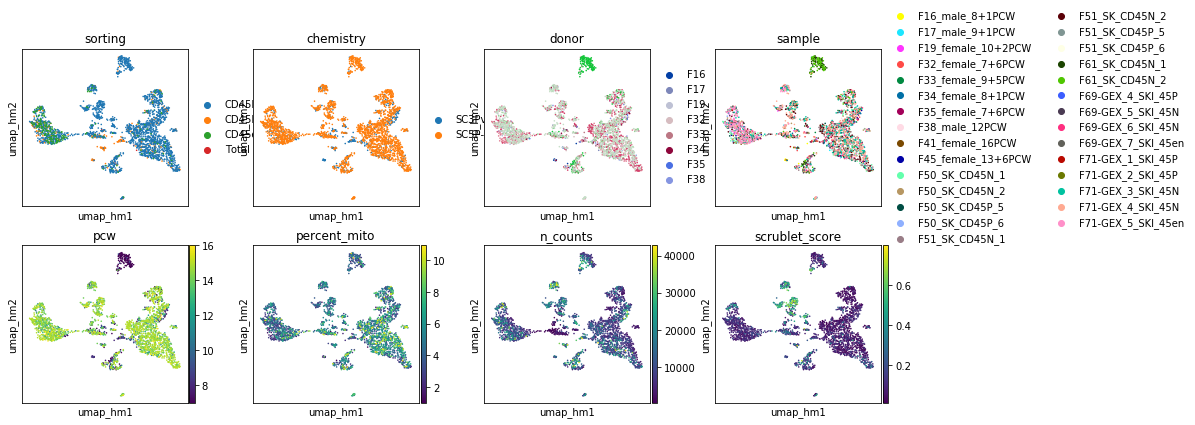

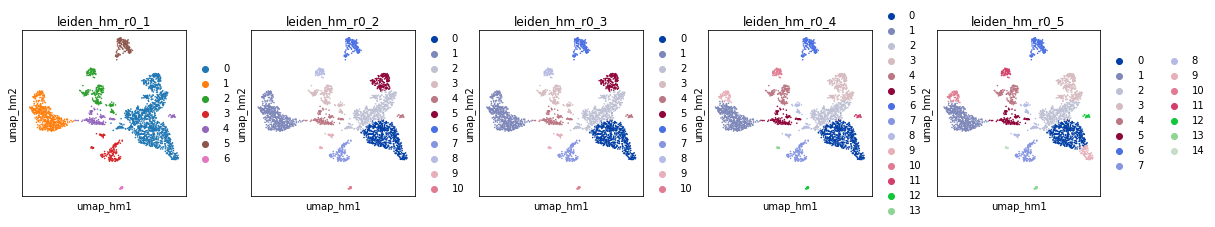

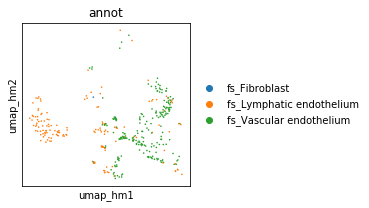

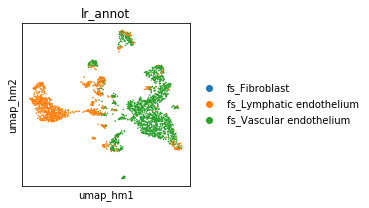

                    freq         p
leiden_hm_r0_3                    
0               0.011218  0.802679
1               0.024390  0.802679
2               0.005405  0.802679
3               0.147959  0.001830
4               0.050847  0.753586
5               0.000000  0.802679
6               0.000000  0.802679
7               0.028369  0.802679
8               0.048387  0.753586
9               0.029412  0.802679
10              0.052632  0.753586
                   score         p
leiden_hm_r0_3                    
0               0.074486  0.874678
1               0.101745  0.821437
2               0.062749  0.874678
3               0.363695  0.000612
4               0.131551  0.821437
5               0.044267  0.874678
6               0.117460  0.821437
7               0.157221  0.732313
8               0.313611  0.005718
9               0.174576  0.678348
10              0.109313  0.821437


In [58]:
ss.lib.set_figsize((3,3))
plot_scatter(
    ad1, basis='umap_hm', size=10,
    color=['sorting', 'chemistry', 'donor', 'sample', 'pcw', 'percent_mito', 'n_counts', 'scrublet_score'])
plot_scatter(
    ad1, basis='umap_hm', size=10, ncols=len(CLUSTER_RESOLUTIONS),
    color=[f'leiden_hm_r{str(res).replace(".", "_")}' for res in CLUSTER_RESOLUTIONS])
plot_scatter(ad1[k_annot, :], basis='umap_hm', size=10, color='annot')
plot_scatter(ad1, basis='umap_hm', size=10, color='lr_annot')


doublet_freq = ad1.obs.groupby('leiden_hm_r0_3')['doublet'].agg(lambda x: sum(x)/len(x))
_, p = ss.lib.test_outlier(doublet_freq, upper_mad_only=False)
print(pd.DataFrame({'freq': doublet_freq, 'p': p}))

doublet_freq = ad1.obs.groupby('leiden_hm_r0_3')['scrublet_score'].agg(lambda x: sum(x)/len(x))
_, p = ss.lib.test_outlier(doublet_freq, upper_mad_only=False)
print(pd.DataFrame({'score': doublet_freq, 'p': p}))

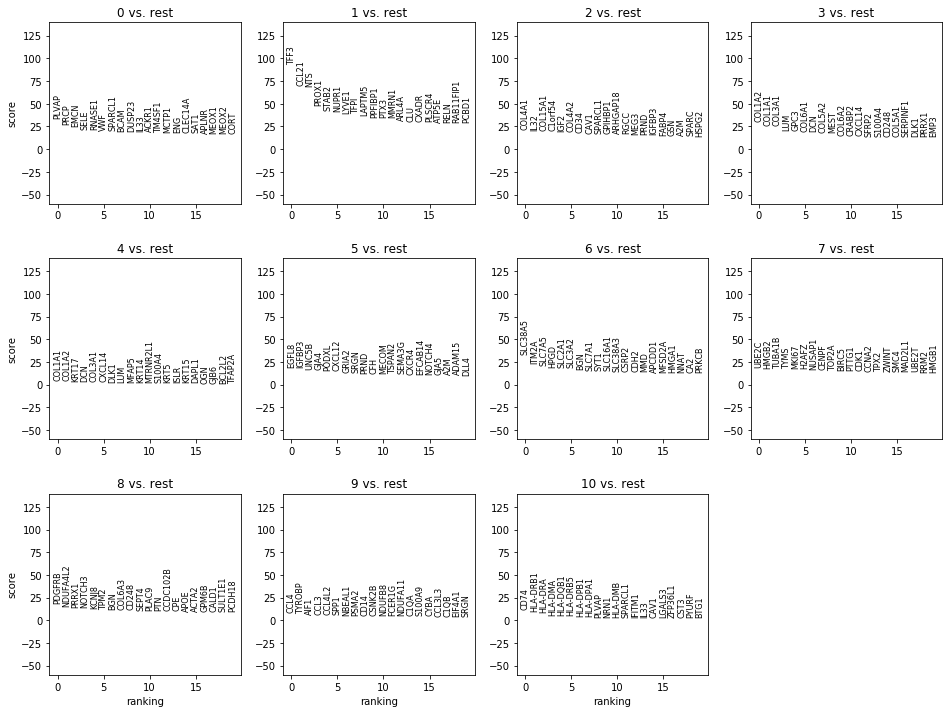

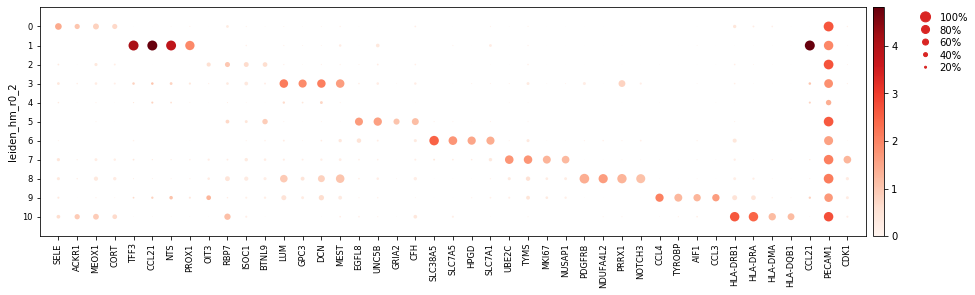

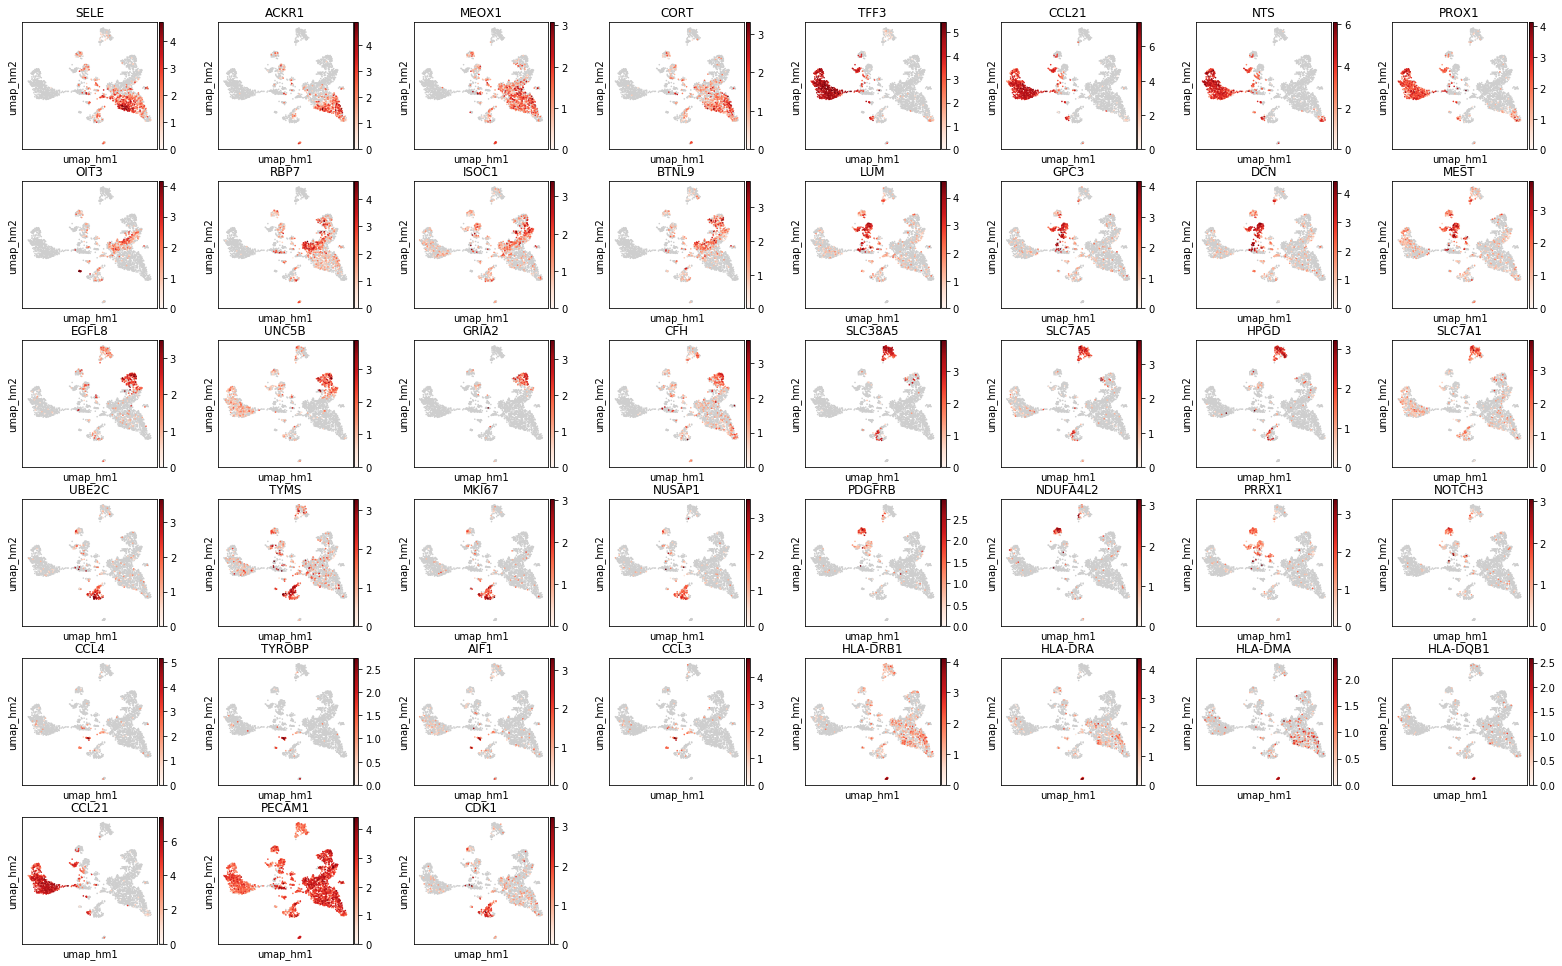

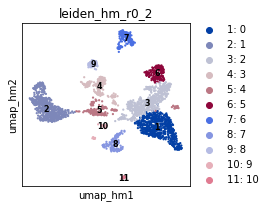

In [54]:
DE_RES = 0.2

hm_de_genes1 = diffexp(
    ad1, basis='umap', key='hm', res=DE_RES, method=DE_METHOD,
    filter_params=DE_FILTERS,
    extra_genes=KNOWN_MARKERS + ['CDK1']
)
hm_de_genes1.groupby('cluster').head(5)

res = str(DE_RES).replace(".", "_")
hm_de_genes1.groupby('cluster').head(30).to_csv(
    f'2.{CATEGORY_CLUSTER_ID+1}_{CATEGORY_NAME}_harmony_withCC_leiden_r{res}_DE_filtered_top30.txt', sep='\t', index=False)
ss.lib.extract_de_table(ad1.uns[f'rank_genes_groups_hm_r{res}']).groupby('cluster').head(200).to_csv(
    f'2.{CATEGORY_CLUSTER_ID+1}_{CATEGORY_NAME}_harmony_withCC_leiden_r{res}_DE_top200.txt', sep='\t', index=False)

In [38]:
ss.lib.simple_default_pipeline(
    ad2,
    filter_params=None, norm_params=None, hvg_params=None, scale_params=None, pca_params=None,
    harmony_params={'batch': 'sample', 'key_added': 'hm'},
    nb_params={'use_rep': 'X_pca_hm', 'key_added': 'hm'},
    umap_params={'use_graph': 'neighbors_hm', 'key_added': 'hm'},
    leiden_params={'resolution': CLUSTER_RESOLUTIONS, 'use_graph': 'neighbors_hm', 'key_added': 'hm'},
    tsne_params=None, diffmap_params=None, fdg_params=None,
)

AnnData object with n_obs × n_vars = 2692 × 18040 
    obs: 'bh_doublet_pval', 'cell_caller', 'cluster_scrublet_score', 'doublet_pval', 'mt_prop', 'n_counts', 'n_genes', 'sanger_id', 'scrublet_score', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'annot', 'hierarchy1', 'percent_mito', 'percent_ribo', 'percent_hb', 'leiden_orig_r0_1', 'leiden_orig_r0_2', 'leiden_orig_r0_3', 'leiden_orig_r0_4', 'leiden_orig_r0_5', 'lr_annot', 'doublet', 'leiden_hm_r0_1', 'leiden_hm_r0_2', 'leiden_hm_r0_3', 'leiden_hm_r0_4', 'leiden_hm_r0_5'
    var: 'gene_ids', 'cc', 'mito', 'ribo', 'hb', 'n_cells', 'highly_variable'
    uns: 'pca', 'neighbors_orig', 'leiden', 'sorting_colors', 'chemistry_colors', 'donor_colors', 'sample_colors', 'leiden_orig_r0_1_colors', 'leiden_orig_r0_2_colors', 'leiden_orig_r0_3_colors', 'leiden_orig_r0_4_colors', 'leiden_orig_r0_5_colors', 'lr_annot_colors', 'neighbors_hm', 'neighbors'
    obsm: 'X_pca', 'X_umap_orig', 'X_pca_hm', 'X_umap_hm'
    

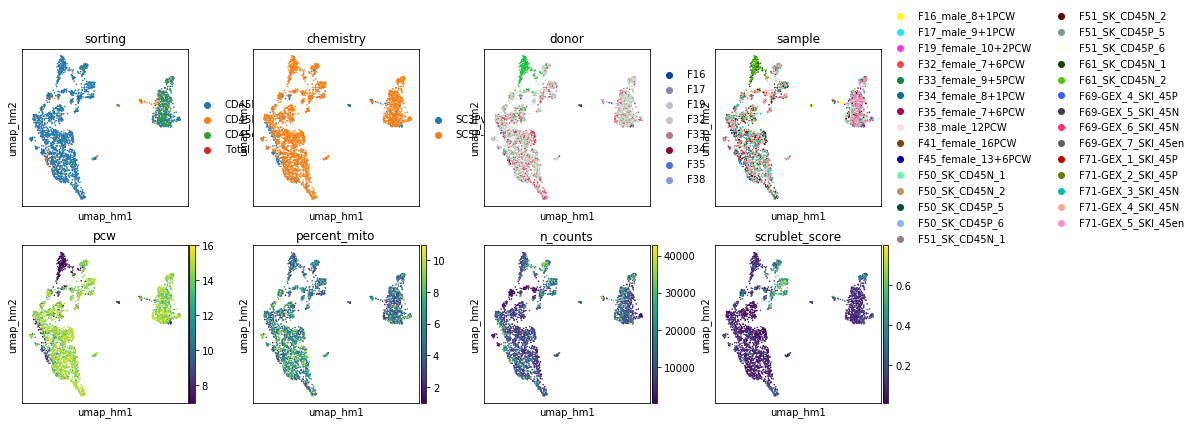

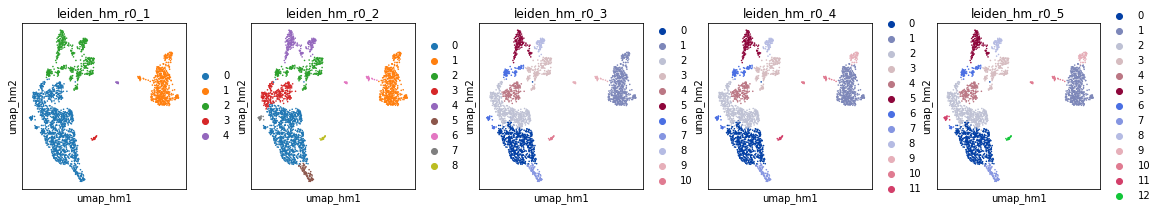

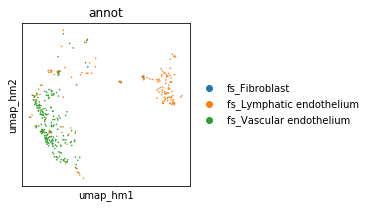

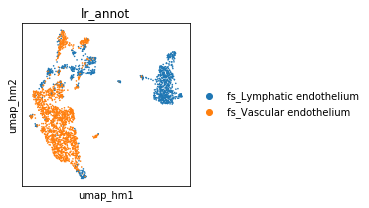

                    freq         p
leiden_hm_r0_3                    
0               0.013294  0.756262
1               0.021739  0.756262
2               0.007561  0.756262
3               0.162037  0.000041
4               0.000000  0.756262
5               0.000000  0.756262
6               0.039062  0.756262
7               0.000000  0.756262
8               0.042857  0.756262
9               0.025641  0.756262
10              0.047619  0.756262
                   score         p
leiden_hm_r0_3                    
0               0.071283  0.843281
1               0.103671  0.832619
2               0.062959  0.843281
3               0.354654  0.010098
4               0.046345  0.843281
5               0.121713  0.832619
6               0.137648  0.832619
7               0.145009  0.832619
8               0.307968  0.035018
9               0.180778  0.787481
10              0.101697  0.832619


In [41]:
ss.lib.set_figsize((3,3))
plot_scatter(
    ad2, basis='umap_hm', size=10,
    color=['sorting', 'chemistry', 'donor', 'sample', 'pcw', 'percent_mito', 'n_counts', 'scrublet_score'])
plot_scatter(
    ad2, basis='umap_hm', size=10, ncols=len(CLUSTER_RESOLUTIONS),
    color=[f'leiden_hm_r{str(res).replace(".", "_")}' for res in CLUSTER_RESOLUTIONS])
plot_scatter(ad2[k_annot, :], basis='umap_hm', size=10, color='annot')
plot_scatter(ad2, basis='umap_hm', size=10, color='lr_annot')


doublet_freq = ad2.obs.groupby('leiden_hm_r0_3')['doublet'].agg(lambda x: sum(x)/len(x))
_, p = ss.lib.test_outlier(doublet_freq, upper_mad_only=False)
print(pd.DataFrame({'freq': doublet_freq, 'p': p}))

doublet_freq = ad2.obs.groupby('leiden_hm_r0_3')['scrublet_score'].agg(lambda x: sum(x)/len(x))
_, p = ss.lib.test_outlier(doublet_freq, upper_mad_only=False)
print(pd.DataFrame({'score': doublet_freq, 'p': p}))

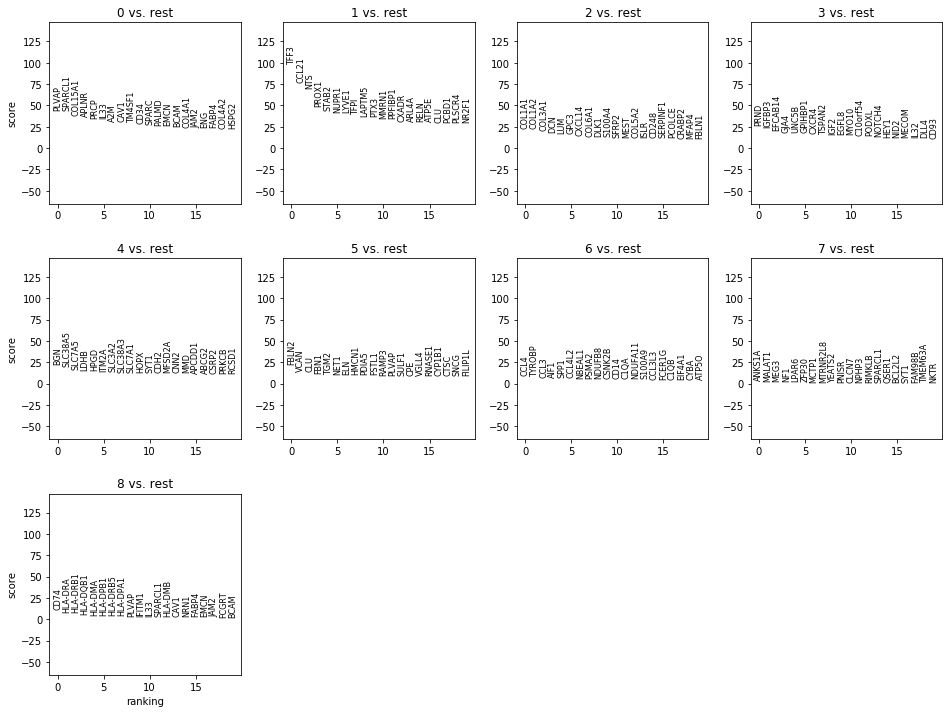

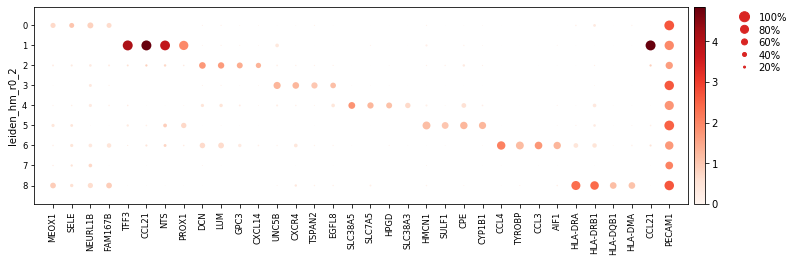

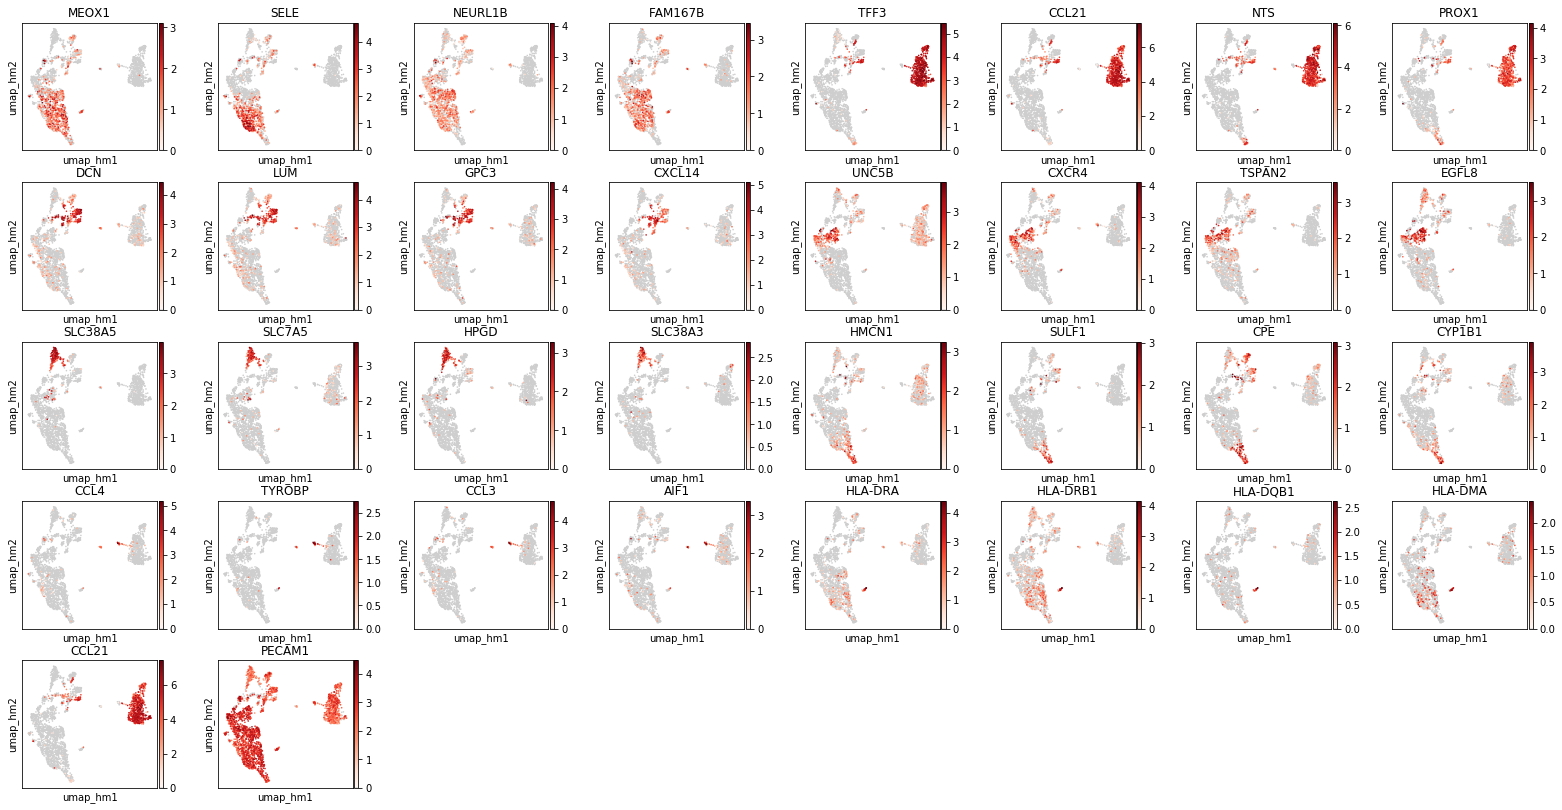

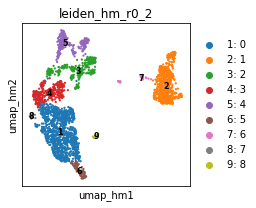

In [59]:
DE_RES = 0.2

hm_de_genes2 = diffexp(
    ad2, basis='umap', key='hm', res=DE_RES, method=DE_METHOD,
    filter_params=DE_FILTERS,
    extra_genes=KNOWN_MARKERS
)
hm_de_genes2.groupby('cluster').head(5)

res = str(DE_RES).replace(".", "_")
hm_de_genes2.groupby('cluster').head(30).to_csv(
    f'2.{CATEGORY_CLUSTER_ID+1}_{CATEGORY_NAME}_harmony_noCC_leiden_r{res}_DE_filtered_top30.txt', sep='\t', index=False)
ss.lib.extract_de_table(ad2.uns[f'rank_genes_groups_hm_r{res}']).groupby('cluster').head(200).to_csv(
    f'2.{CATEGORY_CLUSTER_ID+1}_{CATEGORY_NAME}_harmony_noCC_leiden_r{res}_DE_top200.txt', sep='\t', index=False)

# 4.2 BBKNN

In [42]:
ad1.uns['neighbors'] = ad1.uns['neighbors_orig']
bbknn.bbknn(ad1, batch_key='sample', metric='euclidean', neighbors_within_batch=2, trim=15, copy=False)
ad1.uns['neighbors_bk'] = ad1.uns['neighbors']
ss.lib.umap(ad1, use_graph='neighbors_bk', key_added='bk')
ss.lib.leiden(ad1, use_graph='neighbors_bk', key_added='bk', resolution=CLUSTER_RESOLUTIONS)

AnnData object with n_obs × n_vars = 2692 × 18601 
    obs: 'bh_doublet_pval', 'cell_caller', 'cluster_scrublet_score', 'doublet_pval', 'mt_prop', 'n_counts', 'n_genes', 'sanger_id', 'scrublet_score', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'annot', 'hierarchy1', 'percent_mito', 'percent_ribo', 'percent_hb', 'leiden_orig_r0_1', 'leiden_orig_r0_2', 'leiden_orig_r0_3', 'leiden_orig_r0_4', 'leiden_orig_r0_5', 'lr_annot', 'doublet', 'leiden_hm_r0_1', 'leiden_hm_r0_2', 'leiden_hm_r0_3', 'leiden_hm_r0_4', 'leiden_hm_r0_5', 'leiden_bk_r0_1', 'leiden_bk_r0_2', 'leiden_bk_r0_3', 'leiden_bk_r0_4', 'leiden_bk_r0_5'
    var: 'gene_ids', 'cc', 'mito', 'ribo', 'hb', 'n_cells', 'highly_variable'
    uns: 'pca', 'neighbors_orig', 'leiden', 'sorting_colors', 'chemistry_colors', 'donor_colors', 'sample_colors', 'leiden_orig_r0_1_colors', 'leiden_orig_r0_2_colors', 'leiden_orig_r0_3_colors', 'leiden_orig_r0_4_colors', 'leiden_orig_r0_5_colors', 'lr_annot_colors', 

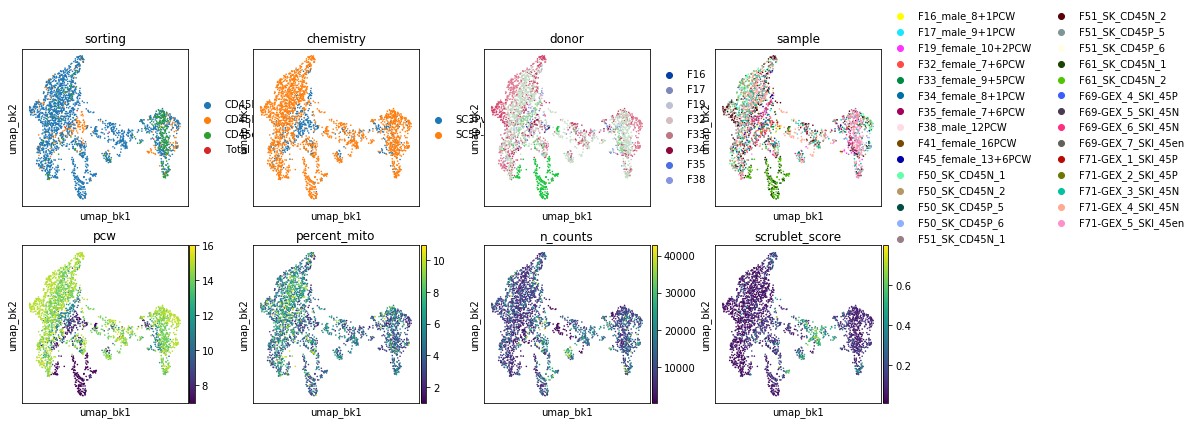

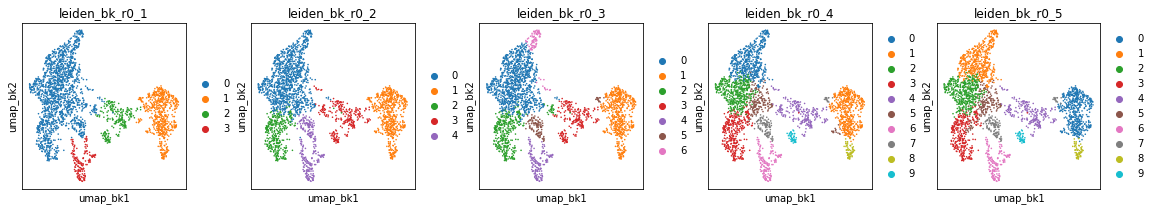

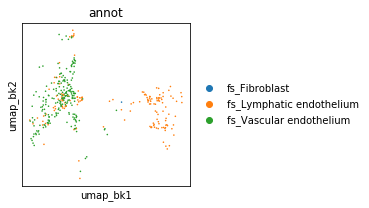

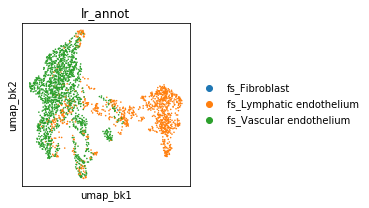

                    freq         p
leiden_bk_r0_3                    
0               0.015770  0.270088
1               0.028476  0.049522
2               0.002519  0.680435
3               0.145228  0.000000
4               0.000000  0.750000
5               0.008264  0.500000
6               0.000000  0.750000
                   score             p
leiden_bk_r0_3                        
0               0.070920  9.458893e-01
1               0.105850  7.500003e-01
2               0.071387  9.445092e-01
3               0.364138  2.561549e-10
4               0.131136  5.000000e-01
5               0.138659  4.204720e-01
6               0.149225  3.147106e-01


In [43]:
ss.lib.set_figsize((3,3))
plot_scatter(
    ad1, basis='umap_bk', size=10,
    color=['sorting', 'chemistry', 'donor', 'sample', 'pcw', 'percent_mito', 'n_counts', 'scrublet_score'])
plot_scatter(
    ad1, basis='umap_bk', size=10, ncols=len(CLUSTER_RESOLUTIONS),
    color=[f'leiden_bk_r{str(res).replace(".", "_")}' for res in CLUSTER_RESOLUTIONS])
plot_scatter(ad1[k_annot, :], basis='umap_bk', size=10, color='annot')
plot_scatter(ad1, basis='umap_bk', size=10, color='lr_annot')


doublet_freq = ad1.obs.groupby('leiden_bk_r0_3')['doublet'].agg(lambda x: sum(x)/len(x))
p, p_adj = ss.lib.test_outlier(doublet_freq, upper_mad_only=False)
print(pd.DataFrame({'freq': doublet_freq, 'p': p}))

doublet_freq = ad1.obs.groupby('leiden_bk_r0_3')['scrublet_score'].agg(lambda x: sum(x)/len(x))
p, p_adj = ss.lib.test_outlier(doublet_freq, upper_mad_only=False)
print(pd.DataFrame({'score': doublet_freq, 'p': p}))

cluster   ref  rank    genes     scores  logfoldchanges          pvals  \
17           0  rest    17     SELE  22.294863        3.601367   1.299987e-94   
18           0  rest    18    MEOX1  22.202755        3.048108   5.106069e-95   
19           0  rest    19  NOSTRIN  22.046202        2.388727   7.705832e-96   
23           0  rest    23  FAM167B  21.334229        2.964462   1.542179e-88   
27           0  rest    27  NEURL1B  20.761427        2.395055   5.459737e-86   
18601        1  rest     0     TFF3  96.084618        8.502233   0.000000e+00   
18602        1  rest     1    CCL21  76.222542        9.202594   0.000000e+00   
18603        1  rest     2      NTS  70.547264        7.707883   0.000000e+00   
18604        1  rest     3    PROX1  48.793850        5.734894  5.676528e-254   
18605        1  rest     4    STAB2  43.352314        6.279485  1.901324e-210   
37205        2  rest     3    CXCR4  16.567070        4.388794   6.714275e-49   
37207        2  rest     5    UNC5B  15.351865        3.315390   3.416148e-44   
37209        2  rest     7   TSPAN2  14.727749        3.810093   9.302712e-41   
37210        2  rest     8    EGFL8  14.361798        3.937913   4.544973e-39   
37218        2  rest    16     HEY1  11.330061        2.747397   5.213430e-27   
55806        3  rest     3      LUM  21.583624        5.071970   8.851906e-65   
55808        3  rest     5      DCN  20.488800        5.083810   5.094048e-60   
55810        3  rest     7     MEST  19.478037        4.138816   2.014543e-57   
55811        3  rest     8    PRRX1  18.963699        5.181062   1.262436e-52   
55812        3  rest     9     GPC3  18.762741        5.236336   5.646596e-52   
74404        4  rest     0  SLC38A5  35.025917        8.582561   1.262384e-84   
74406        4  rest     2   SLC7A5  23.781973        6.608966   2.326313e-58   
74408        4  rest     4     HPGD  20.650644        6.731559   1.807566e-49   
74411        4  rest     7     SYT1  17.425381        4.605966   7.989764e-44   
74413        4  rest     9   SLC7A1  17.122566        4.408730   2.897741e-42   
93006        5  rest     1    UBE2C  17.709705        6.096069   8.198067e-38   
93007        5  rest     2     TYMS  16.810074        4.486812   1.215274e-39   
93008        5  rest     3    MKI67  16.639805        6.082833   1.189007e-34   
93010        5  rest     5    TOP2A  15.767341        5.515274   4.683047e-33   
93012        5  rest     7   NUSAP1  15.491774        5.672745   2.675176e-32   
111613       6  rest     7    HMCN1  10.693871        3.971806   2.127443e-19   
111614       6  rest     8      CPE  10.412310        4.018707   6.955932e-19   
111616       6  rest    10    SULF1  10.216425        5.314295   1.696808e-17   
111622       6  rest    16   CYP1B1   8.836288        4.238330   1.148499e-14   
111624       6  rest    18     SELP   8.613622        4.351340   3.990712e-14   

            pvals_adj  
17       8.636095e-92  
18       3.653000e-92  
19       5.733447e-93  
23       7.548966e-86  
27       2.538914e-83  
18601    0.000000e+00  
18602    0.000000e+00  
18603    0.000000e+00  
18604   1.759818e-250  
18605   3.536653e-207  
37205    1.387691e-45  
37207    4.538840e-41  
37209    1.081498e-37  
37210    4.449529e-36  
37218    2.203977e-24  
55806    3.293086e-61  
55808    1.353634e-56  
55810    4.684063e-54  
55811    2.348258e-49  
55812    9.548395e-49  
74404    2.348161e-80  
74406    6.181678e-55  
74408    2.801878e-46  
74411    8.742212e-41  
74413    2.994494e-39  
93006    3.812306e-34  
93007    1.130266e-35  
93008    3.686120e-31  
93010    1.244419e-29  
93012    6.220119e-29  
111613   3.957257e-16  
111614   1.176248e-15  
111616   2.427872e-14  
111622   9.288361e-12  
111624   2.855048e-11

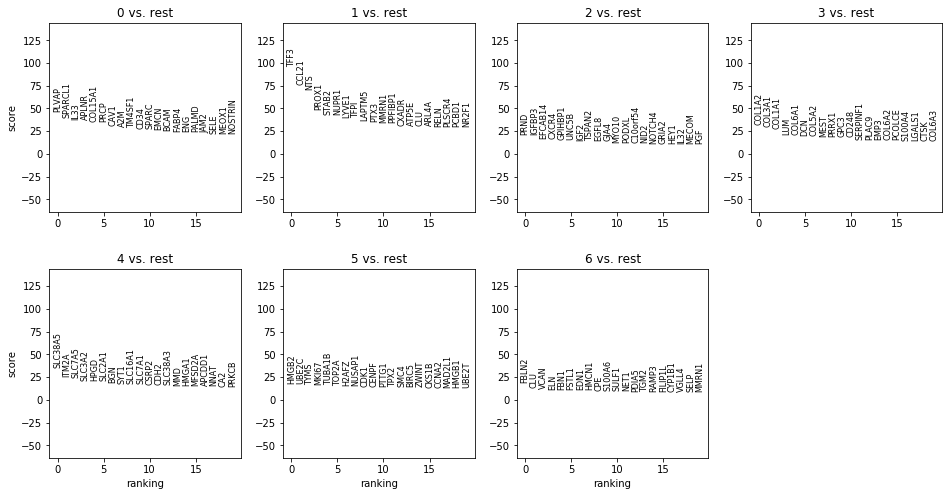

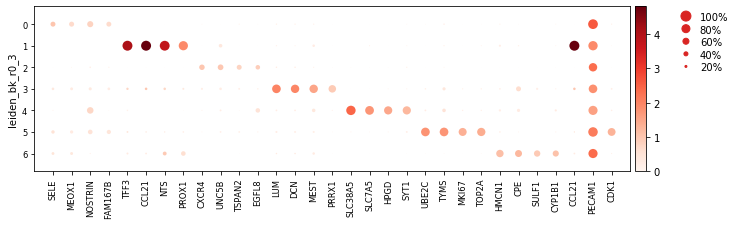

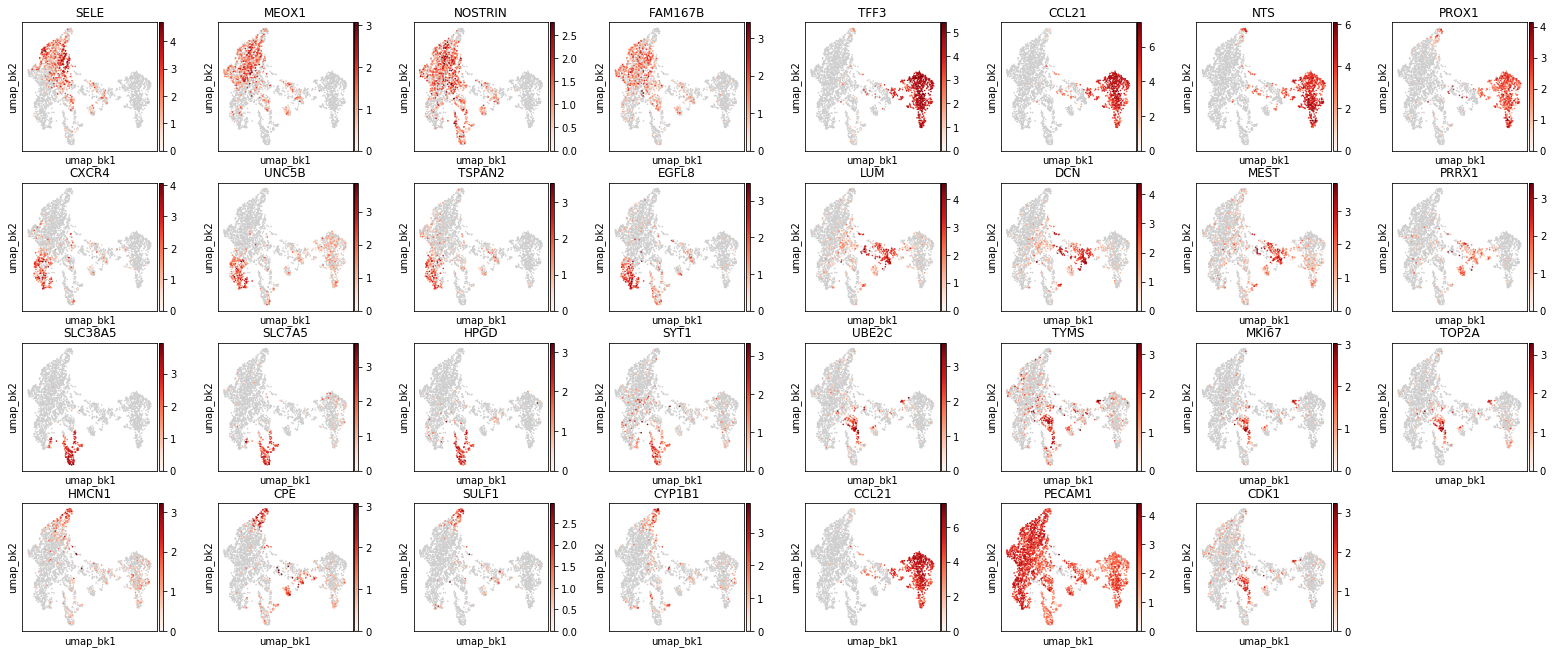

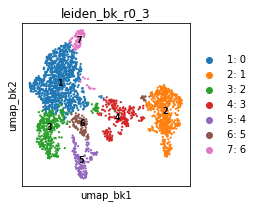

In [61]:
DE_RES = 0.3

bk_de_genes1 = diffexp(
    ad1, basis='umap', key='bk', res=DE_RES, method=DE_METHOD,
    filter_params=DE_FILTERS,
    extra_genes=KNOWN_MARKERS + ['CDK1']
)
bk_de_genes1.groupby('cluster').head(5)

In [44]:
ad2.uns['neighbors'] = ad2.uns['neighbors_orig']
bbknn.bbknn(ad2, batch_key='sample', metric='euclidean', neighbors_within_batch=2, trim=15, copy=False)
ad2.uns['neighbors_bk'] = ad2.uns['neighbors']
ss.lib.umap(ad2, use_graph='neighbors_bk', key_added='bk')
ss.lib.leiden(ad2, use_graph='neighbors_bk', key_added='bk', resolution=CLUSTER_RESOLUTIONS)

AnnData object with n_obs × n_vars = 2692 × 18040 
    obs: 'bh_doublet_pval', 'cell_caller', 'cluster_scrublet_score', 'doublet_pval', 'mt_prop', 'n_counts', 'n_genes', 'sanger_id', 'scrublet_score', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'annot', 'hierarchy1', 'percent_mito', 'percent_ribo', 'percent_hb', 'leiden_orig_r0_1', 'leiden_orig_r0_2', 'leiden_orig_r0_3', 'leiden_orig_r0_4', 'leiden_orig_r0_5', 'lr_annot', 'doublet', 'leiden_hm_r0_1', 'leiden_hm_r0_2', 'leiden_hm_r0_3', 'leiden_hm_r0_4', 'leiden_hm_r0_5', 'leiden_bk_r0_1', 'leiden_bk_r0_2', 'leiden_bk_r0_3', 'leiden_bk_r0_4', 'leiden_bk_r0_5'
    var: 'gene_ids', 'cc', 'mito', 'ribo', 'hb', 'n_cells', 'highly_variable'
    uns: 'pca', 'neighbors_orig', 'leiden', 'sorting_colors', 'chemistry_colors', 'donor_colors', 'sample_colors', 'leiden_orig_r0_1_colors', 'leiden_orig_r0_2_colors', 'leiden_orig_r0_3_colors', 'leiden_orig_r0_4_colors', 'leiden_orig_r0_5_colors', 'lr_annot_colors', 

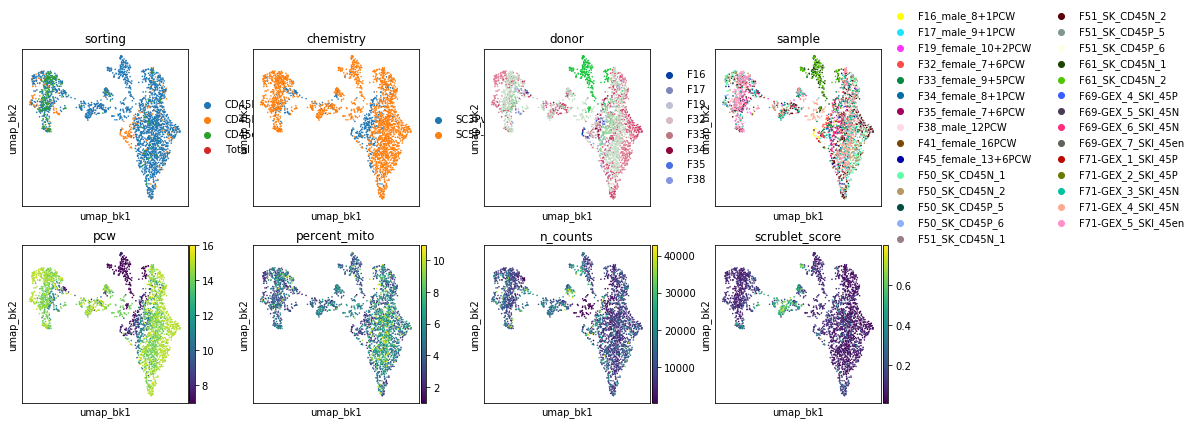

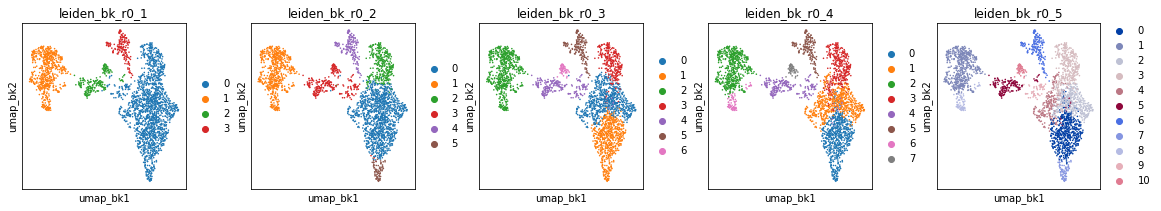

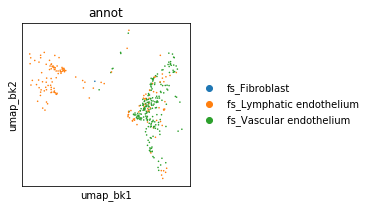

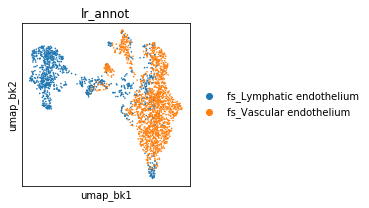

                    freq             p
leiden_bk_r0_3                        
0               0.014245  5.000000e-01
1               0.014263  4.996588e-01
2               0.032000  2.002621e-01
3               0.000000  7.500003e-01
4               0.142857  5.656547e-10
5               0.000000  7.500003e-01
6               0.000000  7.500003e-01
                   score         p
leiden_bk_r0_3                    
0               0.088652  0.687042
1               0.079091  0.750000
2               0.113574  0.500000
3               0.050444  0.891558
4               0.329681  0.000012
5               0.131838  0.360451
6               0.266902  0.001353


In [45]:
ss.lib.set_figsize((3,3))
plot_scatter(
    ad2, basis='umap_bk', size=10,
    color=['sorting', 'chemistry', 'donor', 'sample', 'pcw', 'percent_mito', 'n_counts', 'scrublet_score'])
plot_scatter(
    ad2, basis='umap_bk', size=10, ncols=len(CLUSTER_RESOLUTIONS),
    color=[f'leiden_bk_r{str(res).replace(".", "_")}' for res in CLUSTER_RESOLUTIONS])
plot_scatter(ad2[k_annot, :], basis='umap_bk', size=10, color='annot')
plot_scatter(ad2, basis='umap_bk', size=10, color='lr_annot')


doublet_freq = ad2.obs.groupby('leiden_bk_r0_3')['doublet'].agg(lambda x: sum(x)/len(x))
p, p_adj = ss.lib.test_outlier(doublet_freq, upper_mad_only=False)
print(pd.DataFrame({'freq': doublet_freq, 'p': p}))

doublet_freq = ad2.obs.groupby('leiden_bk_r0_3')['scrublet_score'].agg(lambda x: sum(x)/len(x))
p, p_adj = ss.lib.test_outlier(doublet_freq, upper_mad_only=False)
print(pd.DataFrame({'score': doublet_freq, 'p': p}))

cluster   ref  rank     genes      scores  logfoldchanges  \
14           0  rest    14     CDH13   14.202416        2.346277   
28           0  rest    28      RBP7   11.659531        2.105663   
18045        1  rest     5      SELE   21.342077        3.677183   
18047        1  rest     7     ACKR1   20.794800        4.922052   
18053        1  rest    13      CORT   18.882690        3.356651   
18055        1  rest    15     FBLN2   18.658886        3.371050   
18062        1  rest    22     MEOX1   17.336399        2.578283   
36080        2  rest     0      TFF3  105.689514        9.020215   
36081        2  rest     1     CCL21   84.752373        9.795704   
36082        2  rest     2       NTS   74.726868        8.098329   
36083        2  rest     3     PROX1   51.051735        6.010302   
36084        2  rest     4     STAB2   46.000984        6.824900   
54123        3  rest     3     UNC5B   19.282394        4.011209   
54124        3  rest     4     CXCR4   18.055141        4.784754   
54125        3  rest     5     EGFL8   17.355728        4.715281   
54128        3  rest     8    TSPAN2   15.930287        4.174760   
54133        3  rest    13      HEY1   14.060266        3.485915   
72163        4  rest     3       LUM   23.962511        5.627879   
72164        4  rest     4       DCN   23.859705        5.775501   
72165        4  rest     5      GPC3   21.484745        5.849476   
72166        4  rest     6    CXCL14   17.794937        5.843150   
72169        4  rest     9      MEST   16.590361        4.051457   
90200        5  rest     0   SLC38A5   36.480190        9.137661   
90202        5  rest     2    SLC7A5   23.845016        6.690773   
90204        5  rest     4      HPGD   22.235985        7.196509   
90207        5  rest     7      SYT1   17.746521        4.610064   
90208        5  rest     8    SLC7A1   17.080006        4.383224   
108240       6  rest     0    PDGFRB   17.463242        6.288904   
108241       6  rest     1  NDUFA4L2   14.610714        6.976781   
108242       6  rest     2     KCNJ8   14.311609        7.034636   
108243       6  rest     3    NOTCH3   14.152128        5.615964   
108244       6  rest     4     PRRX1   12.757627        4.613204   

                pvals      pvals_adj  
14       4.489536e-42   2.454280e-39  
28       1.054844e-29   2.378673e-27  
18045    8.613751e-83   2.219887e-79  
18047    6.576594e-76   9.886813e-73  
18053    8.527774e-67   8.546725e-64  
18055    2.392579e-65   2.158107e-62  
18062    1.538163e-59   1.109938e-56  
36080    0.000000e+00   0.000000e+00  
36081    0.000000e+00   0.000000e+00  
36082    0.000000e+00   0.000000e+00  
36083   3.592641e-267  1.080187e-263  
36084   2.258913e-223  4.527866e-220  
54123    4.479322e-59   2.020174e-55  
54124    4.974192e-52   1.495574e-48  
54125    7.277295e-49   1.641030e-45  
54128    1.433896e-43   2.155624e-40  
54133    5.507703e-37   4.967948e-34  
72163    6.936133e-70   3.128196e-66  
72164    9.112344e-69   3.287734e-65  
72165    3.218640e-59   9.677378e-56  
72166    2.984619e-46   5.982502e-43  
72169    3.835167e-44   6.918642e-41  
90200    1.399943e-87   2.525497e-83  
90202    1.536856e-59   3.960697e-56  
90204    4.164777e-54   6.830234e-51  
90207    1.098466e-45   1.165666e-42  
90208    9.154578e-43   8.692031e-40  
108240   9.753942e-27   1.759611e-22  
108241   1.491882e-21   6.728386e-18  
108242   5.584846e-21   2.015012e-17  
108243   3.319779e-22   2.994440e-18  
108244   9.961608e-22   5.990247e-18

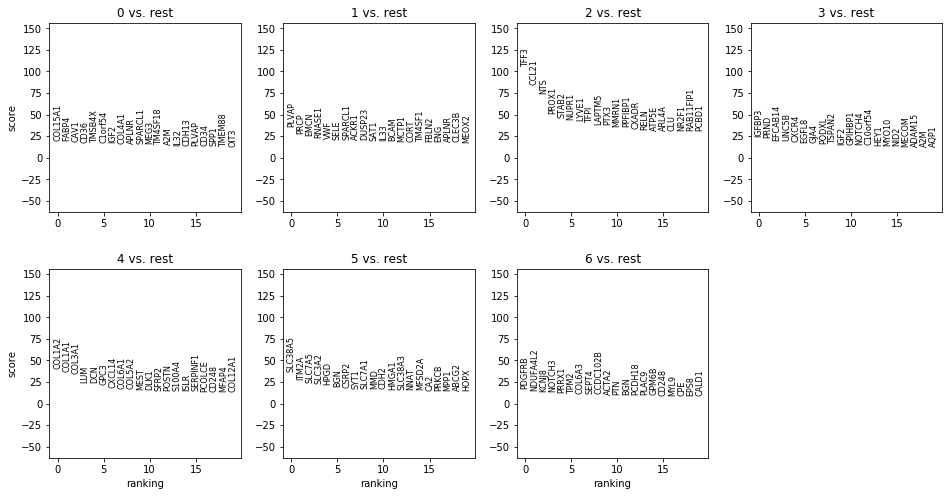

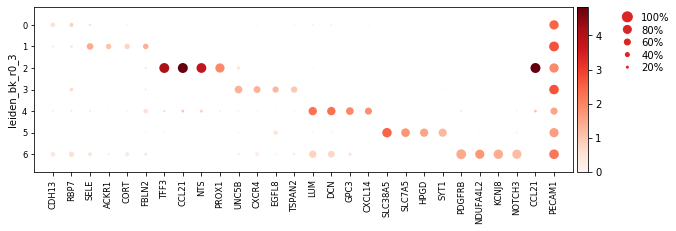

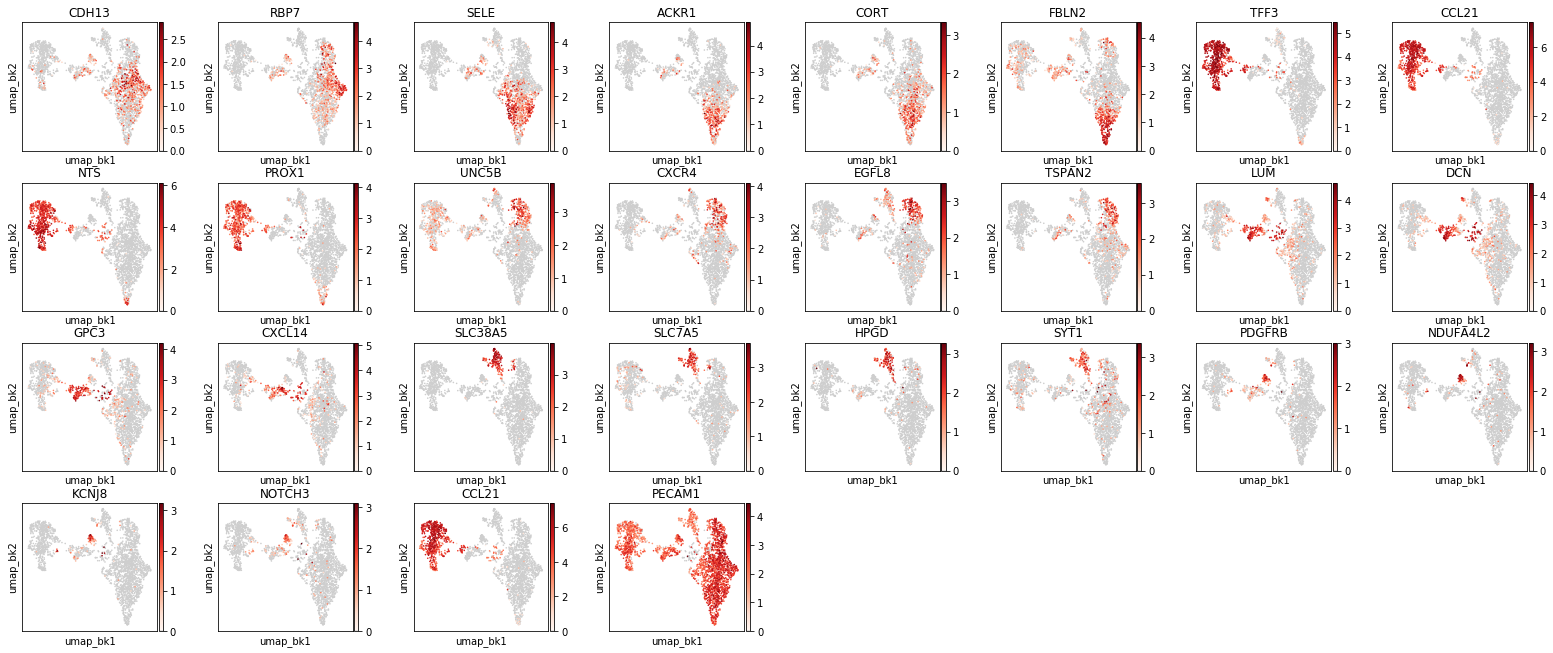

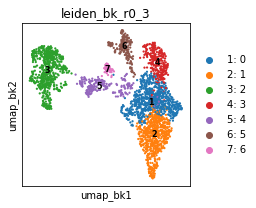

In [62]:
DE_RES = 0.3

bk_de_genes2 = diffexp(
    ad2, basis='umap', key='bk', res=DE_RES, method=DE_METHOD,
    filter_params=DE_FILTERS,
    extra_genes=KNOWN_MARKERS
)
bk_de_genes2.groupby('cluster').head(5)

# 5. Combine clustering and embeddings

In [46]:
ad1.obsm['X_umap_hm_nocc'] = ad2.obsm['X_umap_hm']
ad1.obsm['X_umap_bk_nocc'] = ad2.obsm['X_umap_bk']
for res in CLUSTER_RESOLUTIONS:
    r = str(res).replace(".", "_")
    ad1.obs[f'leiden_hm_nocc_r{r}'] = ad2.obs[f'leiden_hm_r{r}']
    ad1.obs[f'leiden_bk_nocc_r{r}'] = ad2.obs[f'leiden_bk_r{r}']

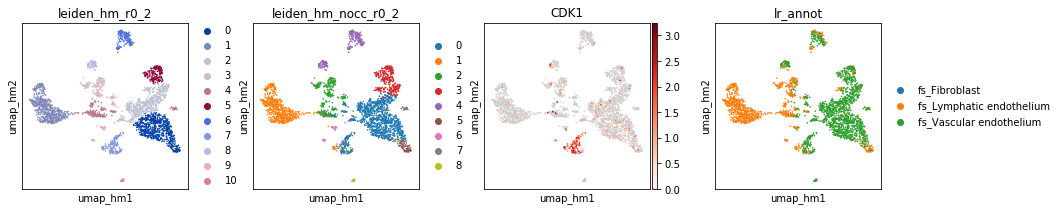

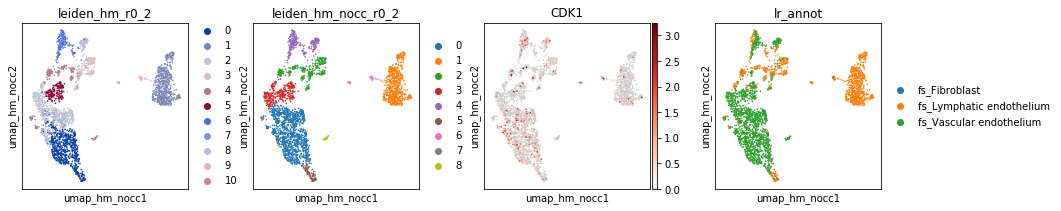

In [53]:
ss.lib.set_figsize((3,3))
plot_scatter(ad1, basis='umap_hm', size=10, color_map=expr_cmap,
             color=['leiden_hm_r0_2', 'leiden_hm_nocc_r0_2', 'CDK1', 'lr_annot'])
plot_scatter(ad1, basis='umap_hm_nocc', size=10, color_map=expr_cmap,
             color=['leiden_hm_r0_2', 'leiden_hm_nocc_r0_2', 'CDK1', 'lr_annot'])

In [63]:
ad1.write(f'data/h5ad/fetal_skin_hierarch1_{CATEGORY_NAME}_processed.h5ad', compression='gzip')
ad2.write(f'data/h5ad/fetal_skin_hierarch1_{CATEGORY_NAME}_processed_nocc.h5ad', compression='gzip')

In [ ]:
# ad1 = sc.read('data/h5ad/fetal_skin_hierarch1_{CATEGORY_NAME}_processed.h5ad')
# ad2 = sc.read('data/h5ad/fetal_skin_hierarch1_{CATEGORY_NAME}_processed_nocc.h5ad')